# Project 1: Digit Classification with KNN and Naive Bayes

In this project, you'll implement your own image recognition system for classifying digits. Read through the code and the instructions carefully and add your own code where indicated. Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but <b> please prepare your own write-up (with your own code). </b>

If you're interested, check out these links related to digit recognition:

* Yann Lecun's MNIST benchmarks: http://yann.lecun.com/exdb/mnist/
* Stanford Streetview research and data: http://ufldl.stanford.edu/housenumbers/

Finally, if you'd like to get started with Tensorflow, you can read through this tutorial: https://www.tensorflow.org/tutorials/keras/basic_classification. It uses a dataset called "fashion_mnist", which is identical in structure to the original digit mnist, but uses images of clothing rather than images of digits. The number of training examples and number of labels is the same. In fact, you can simply replace the code that loads "fashion_mnist" with "mnist" and everything should work fine.

In [3]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

In [4]:
import sklearn
sklearn.__version__

'0.24.2'

In [5]:
import sys
sys.version

'3.9.2 (v3.9.2:1a79785e3e, Feb 19 2021, 09:06:10) \n[Clang 6.0 (clang-600.0.57)]'

Load the data. Notice that the data gets partitioned into training, development, and test sets. Also, a small subset of the training data called mini_train_data and mini_train_labels gets defined, which you should use in all the experiments below, unless otherwise noted.

In [18]:
# Load the digit data from https://www.openml.org/d/554 or from default local location '~/scikit_learn_data/...'
X, Y = fetch_openml(name='mnist_784', return_X_y=True, cache=False)


# Rescale grayscale values to [0,1].
X = X / 255.0


# TP NOTE: Setting a random seed for reproducible results:
np.random.seed(42)

# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X.loc[shuffle], Y.loc[shuffle]

print('data shape: ', X.shape)
print('label shape:', Y.shape)

# Set some variables to hold test, dev, and training data.

# TP NOTE: I have slightly modified the code below using iloc to work 
# with pandas.DataFrames returned by sklearn instead of np.arrays.

test_data, test_labels = X.iloc[61000:], Y.iloc[61000:]
dev_data, dev_labels = X.iloc[60000:61000], Y.iloc[60000:61000]
train_data, train_labels = X.iloc[:60000], Y.iloc[:60000]
mini_train_data, mini_train_labels = X.iloc[:1000], Y.iloc[:1000]

data shape:  (70000, 784)
label shape: (70000,)


### Part 1:

Show a 10x10 grid that visualizes 10 examples of each digit.

Notes:
* You can use `plt.rc()` for setting the colormap, for example to black and white.
* You can use `plt.subplot()` for creating subplots.
* You can use `plt.imshow()` for rendering a matrix.
* You can use `np.array.reshape()` for reshaping a 1D feature vector into a 2D matrix (for rendering).

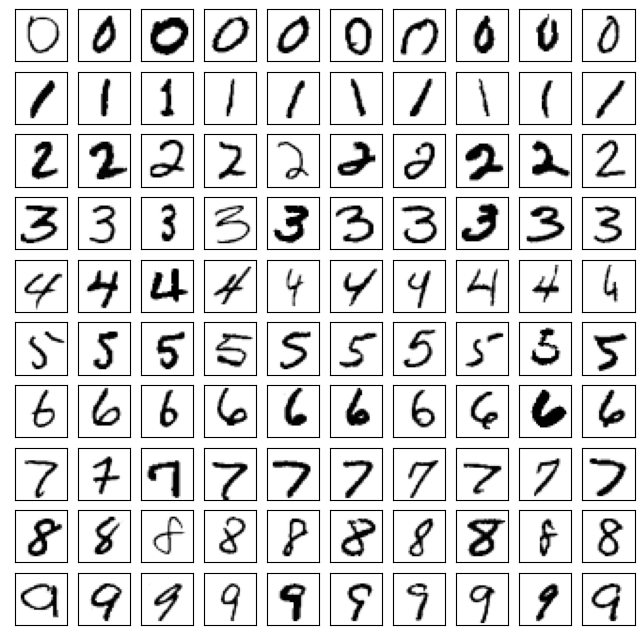

In [20]:
def P1(num_examples: int = 10):
    # Create the figure and subplots:
    fig, axes = plt.subplots(10, num_examples, figsize=(8, 8))
    
    for label in range(10):
        # Grab a random sample of images for each digit:
        indices = np.random.choice(
            mini_train_labels[mini_train_labels == str(label)].index, 
            size=num_examples, replace=False
        )
        # Plot the examples:
        for i in range(num_examples):
            values = mini_train_data.loc[indices].iloc[i].values
            ax = axes[label][i]
            ax.imshow(values.reshape((28, 28)), cmap="Greys")
            ax.set_xticks([])
            ax.set_yticks([])
    return fig


f = P1(10)

### Part 2:

Produce k-Nearest Neighbors models with k $\in$ [1,3,5,7,9].  Evaluate and show the accuracy of each model. For the 1-Nearest Neighbor model, additionally show the precision, recall, and F1 for each label. Which digit is the most difficult for the 1-Nearest Neighbor model to recognize?

Notes:
* Train on the mini train set.
* Evaluate performance on the dev set.
* You can use `KNeighborsClassifier` to produce a k-nearest neighbor model.
* You can use `classification_report` to get precision, recall, and F1 results.

In [21]:
def P2(k_values):
    # Dict to store results where keys are number of neighbors 
    # in KNN model, values are accuracy scores on dev set:
    results = dict()
    for k in k_values:
        model = KNeighborsClassifier(n_neighbors=k, metric="minkowski", p=2)
        model.fit(mini_train_data, mini_train_labels)
        accuracy = model.score(dev_data, dev_labels)
        results[k] = accuracy
    return results


k_values = [1, 3, 5, 7, 9]
P2(k_values)

{1: 0.885, 3: 0.883, 5: 0.88, 7: 0.874, 9: 0.871}

In [22]:
# Fit the KNN model for k=1 to get full scores:
model = KNeighborsClassifier(n_neighbors=1, metric="minkowski", p=2)
model.fit(mini_train_data, mini_train_labels)
pred = model.predict(dev_data)
print(classification_report(dev_labels, pred))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94        97
           1       0.86      1.00      0.92       131
           2       0.96      0.79      0.87        95
           3       0.85      0.89      0.87       110
           4       0.94      0.79      0.86        91
           5       0.83      0.85      0.84        71
           6       0.97      0.94      0.96       102
           7       0.88      0.88      0.88       113
           8       0.90      0.82      0.86       101
           9       0.77      0.88      0.82        89

    accuracy                           0.89      1000
   macro avg       0.89      0.88      0.88      1000
weighted avg       0.89      0.89      0.88      1000



ANSWER:

For `k=1` the digit which is hardest to predict accurately (based on having the lowest F1 score) is 9. It also has the lowest precision (i.e. ratio of correct predictions to total predictions for each digit). However, digits 2 and 4 have the lowest recall scores, meaning they had the highest proportion of False Negatives (i.e. 2s/4s which were classified as other digits).

### Part 3:

Produce 1-Nearest Neighbor models using training data of various sizes.  Evaluate and show the performance of each model.  Additionally, show the time needed to measure the performance of each model.

Notes:
* Train on subsets of the train set.  For each subset, take just the first part of the train set without re-ordering.
* Evaluate on the dev set.
* You can use `KNeighborsClassifier` to produce a k-nearest neighbor model.
* You can use `time.time()` to measure elapsed time of operations.

In [23]:
def P3(train_sizes, accuracies):
    times = list()
    for size in train_sizes:
        t1 = time.time()
        X_train = train_data.iloc[:size] 
        y_train = train_labels.iloc[:size]
        model = KNeighborsClassifier(n_neighbors=1, metric="minkowski", p=2)
        model.fit(X_train, y_train)
        accuracies.append(model.score(dev_data, dev_labels))
        times.append(time.time() - t1)
    return accuracies, times
    
    
train_sizes = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25600]
accuracies = []
P3(train_sizes, accuracies)

([0.722, 0.787, 0.827, 0.878, 0.896, 0.919, 0.941, 0.955, 0.958],
 [0.05753278732299805,
  0.06800389289855957,
  0.0648202896118164,
  0.06380963325500488,
  0.0899350643157959,
  0.13004088401794434,
  0.21761512756347656,
  0.38526391983032227,
  0.789412260055542])

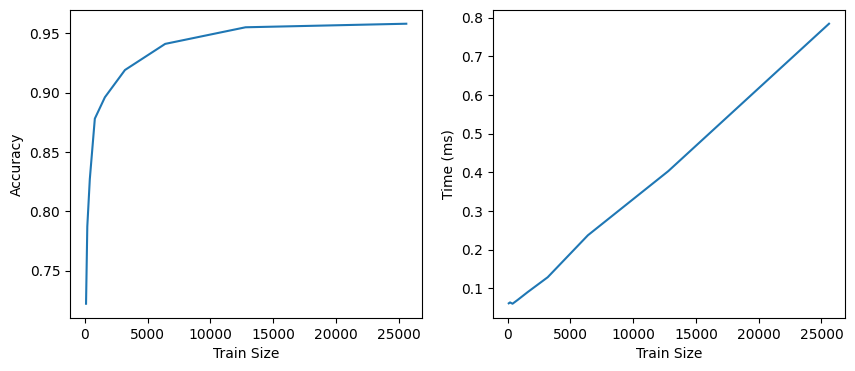

In [25]:
# Plot the difference in rates of increase in accuracy and time as train size increases:
accuracies, times = P3(train_sizes, [])
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(train_sizes, accuracies)
ax[1].plot(train_sizes, times)
ax[0].set_xlabel("Train Size")
ax[0].set_ylabel("Accuracy")
ax[1].set_xlabel("Train Size")
ax[1].set_ylabel("Time (ms)")
plt.show()

### Part 4:

Produce a linear regression model that predicts accuracy of a 1-Nearest Neighbor model given training set size. Show $R^2$ of the linear regression model.  Show the accuracies predicted for training set sizes 60000, 120000, and 1000000.  Show a lineplot of actual accuracies and predicted accuracies vs. training set size over the range of training set sizes in the training data.  What's wrong with using linear regression here?

Apply a transformation to the predictor features and a transformation to the outcome that make the predictions more reasonable.  Show $R^2$ of the improved linear regression model.  Show the accuracies predicted for training set sizes 60000, 120000, and 1000000.  Show a lineplot of actual accuracies and predicted accuracies vs. training set size over the range of training set sizes in the training data - be sure to display accuracies and training set sizes in appropriate units.

Notes:
* Train the linear regression models on all of the (transformed) accuracies estimated in Problem 3.
* Evaluate the linear regression models on all of the (transformed) accuracies estimated in Problem 3.
* You can use `LinearRegression` to produce a linear regression model.
* Remember that the sklearn `fit()` functions take an input matrix X and output vector Y. So, each input example in X is a vector, even if it contains only a single value.
* Hint re: predictor feature transform: Accuracy increases with training set size logarithmically.
* Hint re: outcome transform: When y is a number in range 0 to 1, then odds(y)=y/(1-y) is a number in range 0 to infinity.

R2, untransformed X:                          0.427
Predicted accuracy for 60,000 train size:     1.216
Predicted accuracy for 120,000 train size:    1.591
Predicted accuracy for 1,000,000 train size:  7.095


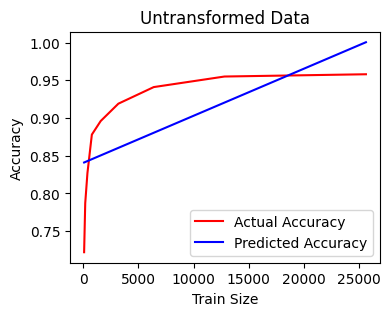

R2, log-transformed X:                        0.944
Predicted accuracy for 60,000 train size:     0.961
Predicted accuracy for 120,000 train size:    0.965
Predicted accuracy for 1,000,000 train size:  0.973


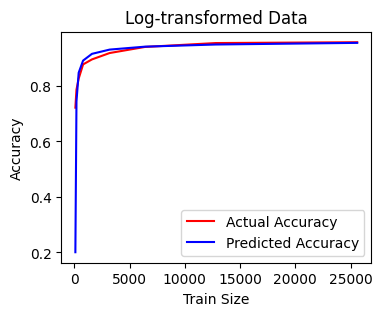

In [26]:
def P4():
    
    def plot(predicted, title: str):
        """Helper function to plot predicted vs. actual accuracy."""
        fig, ax = plt.subplots(figsize=(4, 3))
        ax.plot(train_sizes, accuracies, label="Actual Accuracy", color="r")
        ax.plot(train_sizes, predicted, label="Predicted Accuracy", color="b")
        ax.set_title(title)
        ax.set_xlabel("Train Size")
        ax.set_ylabel("Accuracy")
        ax.legend()
        plt.show()

    # Fit regression with untransformed data:
    X_train = np.array(train_sizes).reshape(len(train_sizes), 1)
    y_train = np.array(accuracies)
    model = LinearRegression(fit_intercept=True)
    model.fit(X_train, y_train)
    r2 = model.score(X_train, y_train)
    print(f"R2, untransformed X:".ljust(45), f"{r2:.3f}")
    for size in (60000, 120000, 1000000):
        pred = model.predict([[size]])[0]
        print(f"Predicted accuracy for {size:,} train size:".ljust(45), f"{pred:.3f}")
    plot(model.predict(X_train), "Untransformed Data")
    
    # Log transform X, odds-transform y, fit new model:
    X_train_log = np.log(X_train)
    y_train_odds = y_train/(1-y_train)
    model = LinearRegression(fit_intercept=True)
    model.fit(X_train_log, y_train_odds)
    r2 = model.score(X_train_log, y_train_odds)
    print(f"R2, log-transformed X:".ljust(45), f"{r2:.3f}")
    for size in (60000, 120000, 1000000):
        pred = model.predict([[np.log(size)]])[0]
        # Convert back to accuracy from odds:
        pred = pred / (pred + 1)
        print(f"Predicted accuracy for {size:,} train size:".ljust(45), f"{pred:.3f}")
    pred = model.predict(X_train_log)
    pred = pred / (pred + 1)
    plot(pred, "Log-transformed Data")


P4()

ANSWER:

The problem with fitting a regression model on the untransformed data is that the relationship is not linear; accuracy increases in proportion to the log of the training size, not the raw value. Also since y is bounded between 0 and 1, a simple linear regression will produce estimates which fall outside the range of possible values for y.

### Part 5:

Produce a 1-Nearest Neighbor model and show the confusion matrix. Which pair of digits does the model confuse most often? Show the images of these most often confused digits.

Notes:
- Train on the mini train set.
- Evaluate performance on the dev set.
- You can use `confusion_matrix()` to produce a confusion matrix.

predicted   0    1   2   3   4   5   6   7   8   9
actual                                            
0          93    0   0   0   0   1   1   0   1   1
1           0  131   0   0   0   0   0   0   0   0
2           2    5  75   5   0   0   0   4   3   1
3           1    0   0  98   0   6   0   1   3   1
4           0    3   2   0  72   0   0   2   0  12
5           0    2   0   4   0  60   2   1   2   0
6           2    3   0   0   0   1  96   0   0   0
7           1    7   0   0   1   0   0  99   0   5
8           2    1   1   6   1   4   0   0  83   3
9           0    1   0   2   3   0   0   5   0  78


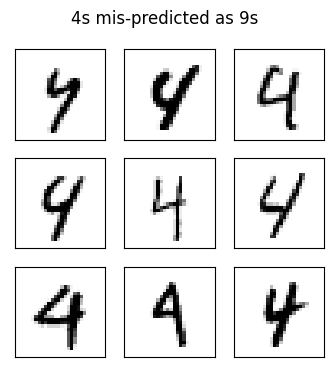

In [27]:
import pandas as pd

def P5():
    # Create the KNN model and produce a DataFrame of the confusion matrix:
    model = KNeighborsClassifier(n_neighbors=1, metric="minkowski", p=2)
    model.fit(mini_train_data, mini_train_labels)
    pred = model.predict(dev_data)
    matrix = confusion_matrix(dev_labels, pred)
    matrix_df = pd.DataFrame(matrix, index=pd.Series(range(0, 10), name="actual"),
                             columns=pd.Series(range(0, 10), name="predicted"))
    print(matrix_df)
    
    # Calculate the pair of digits which were most commonly mis-predicted:
    pair_count = matrix_df.stack().rename("count").reset_index().sort_values(by="count")
    pair = pair_count[pair_count["actual"] != pair_count["predicted"]].iloc[-1]
    actual, prediction = str(pair["actual"]), str(pair["predicted"])
    
    # Create a DataFrame of bad predictions to choose visualization examples from:
    bad_pred_df = pd.DataFrame(dev_labels.rename("actual"))
    bad_pred_df["predicted"] = pred
    bad_pred_df = bad_pred_df[
        (bad_pred_df["actual"] == actual) &
        (bad_pred_df["predicted"] == prediction)
    ]

    # Plot 9 examples of bad predictions:
    fig, axes = plt.subplots(3, 3, figsize=(4, 4))
    for i in range(9):
        ix = bad_pred_df.iloc[i].name
        values = dev_data.loc[ix].values
        ax = axes.flatten()[i]
        ax.imshow(values.reshape((28, 28)), cmap="Greys")
        ax.set_xticks([])
        ax.set_yticks([])
    fig.suptitle(f"{actual}s mis-predicted as {prediction}s")
    plt.show()


df = P5()
df

ANSWER: 

The most often confused digits were 4s which were mis-classiffied by the KNN model as 9s.

### Part 6:

A common image processing technique is to smooth an image by blurring. The idea is that the value of a particular pixel is estimated as the weighted combination of the original value and the values around it. Typically, the blurring is Gaussian, i.e., the weight of a pixel's influence is determined by a Gaussian function over the distance to the relevant pixel.

Implement a simplified Gaussian blur filter by just using the 8 neighboring pixels like this: the smoothed value of a pixel is a weighted combination of the original value and the 8 neighboring values.

Pick a weight, then produce and evaluate four 1-Nearest Neighbor models by applying your blur filter in these ways:
- Do not use the filter
- Filter the training data but not the dev data
- Filter the dev data but not the training data
- Filter both training data and dev data

Show the accuracies of the four models evaluated as described.  Try to pick a weight that makes one model's accuracy at least 0.9.

Notes:
* Train on the (filtered) mini train set.
* Evaluate performance on the (filtered) dev set.
* There are other Guassian blur filters available, for example in `scipy.ndimage.filters`. You are welcome to experiment with those, but you are likely to get the best results with the simplified version described above.

In [28]:
def pixel_neighbors(w: int, h: int) -> dict:
    """Helper function to get the indices of each pixel's immediate 
    neighbors, accounting for edges and corners. For an image of 
    width w, height h, returns a dict where keys are each pixel
    index, values are lists of that pixel's immediate neighbors."""
    d = dict()
    for i in range(w * h):
        row, column = i // w, i % w
        neighbors = list()
        if row != 0:
            neighbors.append(i-w)  # Pixel above.
            if column != 0:
                neighbors.append(i-w-1)  # Pixel above-left.
            if column != w-1:
                neighbors.append(i-w+1)  # Pixel above-right.
        if row != h-1:
            neighbors.append(i+w)  # Pixel below.
            if column != 0:
                neighbors.append(i+w-1)  # Pixel below-left.
            if column != w-1:
                neighbors.append(i+w+1)  # Pixel below-right.
        if column != 0:
            neighbors.append(i-1)  # Pixel left.
        if column != w-1:
            neighbors.append(i+1)  # Pixel right.
        
        # Add 1 to indices because pixel indexing starts at 1 in training data:
        neighbors = [i+1 for i in neighbors]
        d[i+1] = sorted(neighbors)
        
    return d

In [29]:
def P6():
    neighbors = pixel_neighbors(28, 28)
    
    def apply_filter(data: pd.DataFrame, weight: float):
        """Helper function to apply filters to copy of training data.
        Filter applied is: 
            weight * pixel + (1-weight) * mean(neighbor_pixels)
        """
        filtered = data.copy()
        filtered.loc[:, :] = np.nan
        for pixel_name in data.columns:
            pixel_index = int(pixel_name.replace("pixel", ""))
            pixel_neighbors = neighbors[pixel_index]
            neighbor_columns = [f"pixel{i}" for i in pixel_neighbors]
            neighbor_mean = data[neighbor_columns].mean(axis=1)
            filtered[pixel_name] = (weight * data[pixel_name]) + ((1-weight) * neighbor_mean)
        return filtered
    
    # No filters:
    model = KNeighborsClassifier(n_neighbors=1, p=2, metric="minkowski")
    model.fit(mini_train_data, mini_train_labels)
    accuracy = model.score(dev_data, dev_labels)
    print(f"Raw train, raw dev:".ljust(30), f"{accuracy:.3f}")

    for weight in np.arange(0, 1, 0.1):
        print(f"\n{weight=:.1f}")
    
        # Filtered training data, raw dev data:
        train_filtered = apply_filter(mini_train_data, weight=weight)
        model = KNeighborsClassifier(n_neighbors=1, p=2, metric="minkowski")
        model.fit(train_filtered, mini_train_labels)
        accuracy = model.score(dev_data, dev_labels)
        print(f"Filtered train, raw dev:".ljust(30), f"{accuracy:.3f}")

        # Raw training data, filtered dev data:
        dev_filtered = apply_filter(dev_data, weight=weight)
        model = KNeighborsClassifier(n_neighbors=1, p=2, metric="minkowski")
        model.fit(mini_train_data, mini_train_labels)
        accuracy = model.score(dev_filtered, dev_labels)
        print(f"Raw train, filtered dev:".ljust(30), f"{accuracy:.3f}")

        # Filtered training data, filtered dev data:
        model = KNeighborsClassifier(n_neighbors=1, p=2, metric="minkowski")
        model.fit(train_filtered, mini_train_labels)
        accuracy = model.score(dev_filtered, dev_labels)
        print(f"Filtered train, filtered dev:".ljust(30), f"{accuracy:.3f}")

    
P6()

Raw train, raw dev:            0.885

weight=0.0
Filtered train, raw dev:       0.914
Raw train, filtered dev:       0.873
Filtered train, filtered dev:  0.906

weight=0.1
Filtered train, raw dev:       0.908
Raw train, filtered dev:       0.877
Filtered train, filtered dev:  0.905

weight=0.2
Filtered train, raw dev:       0.905
Raw train, filtered dev:       0.877
Filtered train, filtered dev:  0.906

weight=0.3
Filtered train, raw dev:       0.906
Raw train, filtered dev:       0.880
Filtered train, filtered dev:  0.903

weight=0.4
Filtered train, raw dev:       0.903
Raw train, filtered dev:       0.885
Filtered train, filtered dev:  0.901

weight=0.5
Filtered train, raw dev:       0.899
Raw train, filtered dev:       0.887
Filtered train, filtered dev:  0.894

weight=0.6
Filtered train, raw dev:       0.898
Raw train, filtered dev:       0.886
Filtered train, filtered dev:  0.890

weight=0.7
Filtered train, raw dev:       0.892
Raw train, filtered dev:       0.891
Filtered train, 

### Part 7:

Produce two Naive Bayes models and evaluate their performances.  Recall that Naive Bayes estimates P(feature|label), where each label is a categorical, not a real number.

For the first model, map pixel values to either 0 or 1, representing white or black - you should pre-process the data or use `BernoulliNB`'s `binarize` parameter to set the white/black separation threshold to 0.1.  Use `BernoulliNB` to produce the model.

For the second model, map pixel values to either 0, 1, or 2, representing white, gray, or black - you should pre-process the data, seting the white/gray/black separation thresholds to 0.1 and 0.9.  Use `MultinomialNB` to produce the model. 

Show the Bernoulli model accuracy and the Multinomial model accuracy.

Notes:
* Train on the mini train set.
* Evaluate performance on the dev set.
* `sklearn`'s Naive Bayes methods can handle real numbers, but for this exercise explicitly do the mapping to categoricals. 

Does the multinomial version improve the results? Why or why not?

In [39]:
import warnings
# Warning suppression is used to filter out warnings when alpha=0, discussed here: 
# https://github.com/scikit-learn/scikit-learn/issues/10772

def P7():

    # Bernoulli model:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        model = BernoulliNB(alpha=0, binarize=0.1, fit_prior=True)
        model.fit(mini_train_data, mini_train_labels)
        accuracy = model.score(dev_data, dev_labels)
        print(f"Bernoulli model:".ljust(20), f"{accuracy:.3f}")

    def discretize(boundaries: list, data: pd.DataFrame):
        """Helper function to convert continous values into 
        multinomial discrete categories."""
        continuous_values = data.values.copy()
        discrete_values = np.zeros(continuous_values.shape)
        boundaries.append(np.inf)
        lower_bound = -np.inf
        for i, upper_bound in enumerate(boundaries):
            discrete_values = np.where((lower_bound <= continuous_values) & (continuous_values < upper_bound), 
                                        i, discrete_values)
            lower_bound = upper_bound
        return pd.DataFrame(discrete_values, index=data.index, columns=data.columns) 
    
    # Multinomial model:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        model = MultinomialNB(alpha=0, fit_prior=True)
        multinomial_train = discretize([0.1, 0.9], mini_train_data)
        model.fit(multinomial_train, mini_train_labels)
        multinomial_dev = discretize([0.1, 0.9], dev_data)
        accuracy = model.score(multinomial_dev, dev_labels)
        print(f"Multinomial model:".ljust(20), f"{accuracy:.3f}")

    
P7()

Bernoulli model:     0.821
Multinomial model:   0.805


ANSWER:

The BernoulliNB model treats any pixel value above 0.1 as 1, and anything below as 0 so there are effectively 2 categories of possible values for each pixel. The MultiNomial model attempts to add more information by applying 3 categories of pixel values: between 0 and 0.1, between 0.1 and 0.9, and above 0.9. The model does not perform any better with this additional nuance in the information; this means that for predictive purposes the relative magnitude of the pixel value doesn't provide any extra useful information for the model (at least using the boundaries of 0.1 and 0.9); it is more important just to know whether or not the pixel contains a value.

### Part 8:

Search across several values of the LaPlace smoothing parameter (alpha) to find its effect on a Bernoulli Naive Bayes model's performance.  Show the accuracy at each alpha value.

Notes:
* Set binarization threshold to 0.
* Train on the mini train set.
* Evaluate performance by 5-fold cross-validation. 
* Use `GridSearchCV(..., ..., cv=..., scoring='accuracy', iid=False)` to vary alpha and evaluate performance by cross-validation.
* Cross-validation is based on partitions of the training data, so results will be a bit different than if you had used the dev set to evaluate performance.

What is the best value for alpha? What is the accuracy when alpha is near 0? Is this what you'd expect?

In [41]:
def P8(alphas):
    
    estimator = BernoulliNB(binarize=0, fit_prior=True)
    gs = GridSearchCV(estimator, alphas, scoring="accuracy", cv=5)
    gs.fit(mini_train_data, mini_train_labels)
    for alpha, score in zip(alphas["alpha"], gs.cv_results_["mean_test_score"]):
        print(f"{alpha=}".ljust(15), f"{score:.3f}")
    return gs


alphas = {'alpha': [1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
nb = P8(alphas)
print()
print("Best alpha = ", nb.best_params_["alpha"])

alpha=1e-10     0.803
alpha=0.0001    0.808
alpha=0.001     0.808
alpha=0.01      0.810
alpha=0.1       0.810
alpha=0.5       0.803
alpha=1.0       0.801
alpha=2.0       0.802
alpha=10.0      0.775

Best alpha =  0.01


ANSWER:

When `alpha` is near zero (1e-10) accuracy (0.803) is close to the Bernoulli model scored on the development data using `alpha=0` in Part 7 (0.821). This makes sense because the results should be similar since the models are effectively the same, but you would expect some difference as a result of using different datasets to score performance.

### Part 9:

Produce a model using Gaussian Naive Bayes, which is intended for real-valued features, and evaluate performance. You will notice that it does not work so well. Diagnose the problem and apply a simple fix so that the model accuracy is around the same as for a Bernoulli Naive Bayes model. Show the model accuracy before your fix and the model accuracy after your fix.  Explain your solution.

Notes:
* Train on the mini train set.
* Evaluate performance on the dev set.
* Consider the effects of theta and sigma.  These are stored in the model's `theta_` and `sigma_` attributes.

In [42]:
def P9():
    model = GaussianNB()
    model.fit(mini_train_data, mini_train_labels)
    accuracy = model.score(dev_data, dev_labels)
    print(f"Simple GaussianNB model:".ljust(30), f"{accuracy:.3f}")

    # Change all standard deviations to various fixed values betyween 0 and 1:
    for sigma in (0.01, 0.1, 0.2, 0.5, 1):
        model.sigma_ = np.ones(model.sigma_.shape) * sigma
        accuracy = model.score(dev_data, dev_labels)
        print(f"With sigma = {sigma:.2f}:".ljust(30), f"{accuracy:.3f}")
    
    # Improve performance by using GridSearch to tune var_smoothing parameter:
    var_smoothing = {"var_smoothing": np.linspace(1.0e-9, 1, 10)}
    estimator = GaussianNB()
    gs = GridSearchCV(estimator, var_smoothing, scoring="accuracy", cv=5)
    gs.fit(mini_train_data, mini_train_labels)
    var_smoothing = gs.best_params_["var_smoothing"]
    
    # Fit model again with optimal var_smoothing parameter:
    model = GaussianNB(var_smoothing=var_smoothing)
    model.fit(mini_train_data, mini_train_labels)
    accuracy = model.score(dev_data, dev_labels)
    print(f"With var_smoothing = {var_smoothing:.2f}:".ljust(30), f"{accuracy:.3f}")

    
P9()

Simple GaussianNB model:       0.565
With sigma = 0.01:             0.815
With sigma = 0.10:             0.814
With sigma = 0.20:             0.815
With sigma = 0.50:             0.811
With sigma = 1.00:             0.809
With var_smoothing = 0.11:     0.793


ANSWER:

The Bernoulli Naive Bayes model with binarize threshold zero treats all non-zero values in a pixel as contributing an equal amount of information to the model's classification decision. The Gaussian model assumes all features are Gaussian in distribution, and calculates the mean and standard deviation of each feature to use as the parameters for an estimated Normal distribution for that feature. The problem with this is that the estimated standard deviations are likely to vary a lot between different pixels, depending on how many non-zero values each pixel has in the training data, and the spread of those values. This means that pixel values will contribute unequal amounts of information to the Gaussian model's classification decision, even when their values are the same. The fix applied attempts to counter this by applying a uniform standard deviation for all pixels so that the Gaussian distribution at least covers the same 'portion' of the number line for each pixel. This should ensure that the probabilities assigned to each pixel value are closer to each other in magnitude, making the model more simiar to the Bernoulli Naive Bayes model. Based on the values tested above, the optimal value to set as the uniform standard deviation is approximately 0.2.

We can also use GridSearch to tune the `var_smoothing` parameter, which achieves a similar effect by adding a scalar value to the variance calculated for each feature, to widen the range of samples it uses away from the mean.

### Part 10:

Because Naive Bayes produces a generative model, you can use it to generate digit images.

Produce a Bernoulli Naive Bayes model and then use it to generate a 10x20 grid with 20 example images of each digit. Each pixel output should be either 0 or 1, based on comparing some randomly generated number to the estimated probability of the pixel being either 0 or 1.  Show the grid.

Notes:
* You can use np.random.rand() to generate random numbers from a uniform distribution.
* The estimated probability of each pixel being 0 or 1 is stored in the model's `feature_log_prob_` attribute. You can use `np.exp()` to convert a log probability back to a probability.

How do the generated digit images compare to the training digit images?

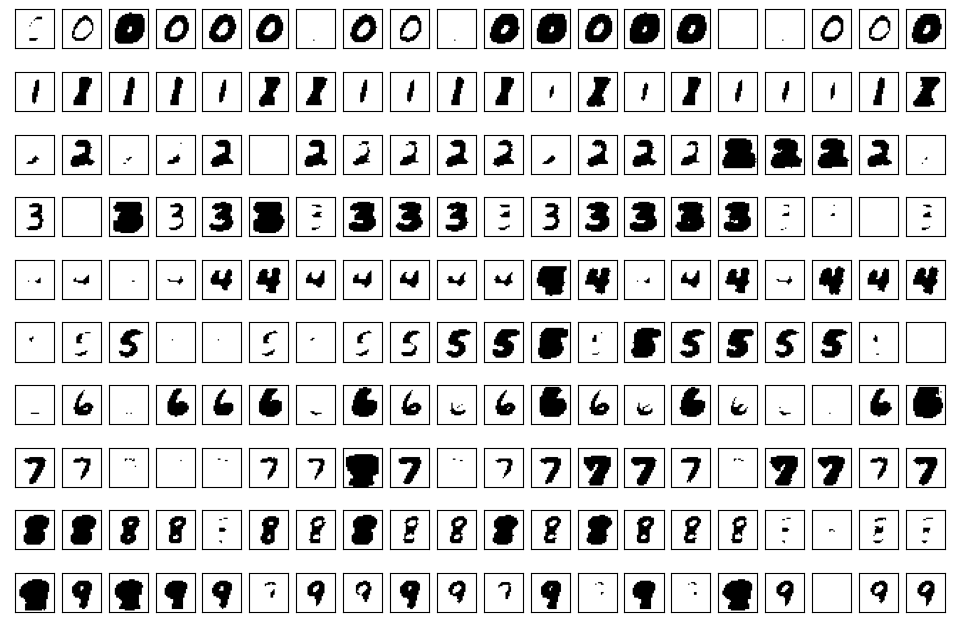

In [43]:
def P10(num_examples):
    
    # Create the simple Bernoulli model:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model = BernoulliNB(alpha=0, binarize=0, fit_prior=True)
        model.fit(mini_train_data, mini_train_labels)
    
    # Convert log prob to probabilities:
    probabilities = np.exp(model.feature_log_prob_)
    
    # Create the plots:
    fig, axes = plt.subplots(10, num_examples, figsize=(12, 8))
    for label in range(10):
        for i in range(num_examples):
            pixels = np.where(probabilities[label] > np.random.rand(1), 1, 0).reshape((28, 28))
            ax = axes[label][i]
            ax.imshow(pixels, cmap="Greys")
            ax.set_xticks([])
            ax.set_yticks([])


P10(20)

ANSWER:

The generated images do not have as much variation as the training data, they are sort of Platonic ideals of each digit based on the 'average' of all digit examples in the training set, each with the same 'slant' and position. The effect of random number generator which tunes the switching on or off of pixels in each image is that as the random number gets smaller, more pixels at the edges of each digit are switched on, 'thickening' the digit, to the point where some of the images become thick blurry blobs. If the random number was zero we would see every pixel switched on which had a non-zero value in any of the training examples for that digit. As the random number gets larger, fewer and fewer pixels are switched on, meaning that some images are completely empty.

### Part 11:

Recall that a strongly calibrated classifier is rougly 90% accurate when the posterior probability of the predicted class is 0.9. A weakly calibrated classifier is more accurate when the posterior probability of the predicted class is 90% than when it is 80%. A poorly calibrated classifier has no positive correlation between posterior probability and accuracy.  

Produce a Bernoulli Naive Bayes model.  Evaluate performance: partition the dev set into several buckets based on the posterior probabilities of the predicted classes - think of a bin in a histogram- and then estimate the accuracy for each bucket. So, for each prediction, find the bucket to which the maximum posterior probability belongs, and update "correct" and "total" counters accordingly.  Show the accuracy for each bucket.

Notes:
* Set LaPlace smoothing (alpha) to the optimal value (from part 8).
* Set binarization threshold to 0.
* Train on the mini train set.
* Evaluate perfromance on the dev set.

How would you characterize the calibration for this Bernoulli Naive Bayes model?

In [44]:
def P11(buckets, correct, total):
    
    # Create the Bernoulli model:
    model = BernoulliNB(alpha=0.001, binarize=0, fit_prior=True)
    model.fit(mini_train_data, mini_train_labels)

    # Construct DataFrame with class labels, predictions, and probabilities:
    pred_df = pd.DataFrame(dev_labels)
    pred_df["probability"] = np.amax(model.predict_proba(dev_data), axis=1)
    pred_df["prediction"] = model.predict(dev_data)

    # 1/0 for Correct/Incorrect predictions for easy summing:
    pred_df["is_correct"] = (pred_df["prediction"] == pred_df["class"]).astype(int)
    
    # Iterate the buckets recording the results:
    lower_bound = -np.inf
    for i, upper_bound in enumerate(buckets):
        subset = pred_df[(pred_df["probability"] > lower_bound) & (pred_df["probability"] <= upper_bound)]
        total[i] = len(subset)
        correct[i] = subset["is_correct"].sum()
        lower_bound = upper_bound
        

buckets = [0.5, 0.9, 0.999, 0.99999, 0.9999999, 0.999999999, 0.99999999999, 0.9999999999999, 1.0]
correct = [0 for i in buckets]
total = [0 for i in buckets]

P11(buckets, correct, total)

for i in range(len(buckets)):
    accuracy = 0.0
    if (total[i] > 0): accuracy = correct[i] / total[i]
    print('p(pred) is %.13f to %.13f    total = %3d    accuracy = %.3f' % (0 if i==0 else buckets[i-1], buckets[i], total[i], accuracy))

p(pred) is 0.0000000000000 to 0.5000000000000    total =   1    accuracy = 0.000
p(pred) is 0.5000000000000 to 0.9000000000000    total =  23    accuracy = 0.217
p(pred) is 0.9000000000000 to 0.9990000000000    total =  56    accuracy = 0.464
p(pred) is 0.9990000000000 to 0.9999900000000    total =  70    accuracy = 0.500
p(pred) is 0.9999900000000 to 0.9999999000000    total =  51    accuracy = 0.529
p(pred) is 0.9999999000000 to 0.9999999990000    total =  47    accuracy = 0.702
p(pred) is 0.9999999990000 to 0.9999999999900    total =  44    accuracy = 0.705
p(pred) is 0.9999999999900 to 0.9999999999999    total =  36    accuracy = 0.722
p(pred) is 0.9999999999999 to 1.0000000000000    total = 672    accuracy = 0.955


ANSWER:

The model is weakly calibrated, because the accuracy increases as the posterior probability increases. It is not strongly calibrated because it produces very over-confident estimates of probability; for example the first bucket in which it is >99% confident has an accuracy of less than 50%.

### Part 12 EXTRA CREDIT:

Design new features to see if you can produce a Bernoulli Naive Bayes model with better performance.  Show the accuracy of a model based on the original features and the accuracy of the model based on the new features.

Here are a few ideas to get you started:
- Try summing or averaging the pixel values in each row.
- Try summing or averaging the pixel values in each column.
- Try summing or averaging the pixel values in each square block. (pick various block sizes)
- Try counting the number of enclosed regions. (8 usually has 2 enclosed regions, 9 usually has 1, and 7 usually has 0)

Notes:
* Train on the mini train set (enhanced to comprise the new features).
* Evaulate performance on the dev set.
* Ensure that your code is well commented.

In [45]:
def pixel_pairs(w: int, h: int, d: int):
    """As an alternative to finding immediate pixel neighbors, this function
    identifies pixels which are `d` distance away from a pixel in the
    vertical and horizontal directions. Returns ordered list of tuples
    of unique pairs of pixels that are `d` distance away from each other."""
    pairs = list()
    left_columns = set(range(0, w-d))
    top_rows = set(range(0, h-d))
    
    for i in range(w * h):
        row, column = i // w, i % w
        if row in top_rows:
            below_index = ((row+d)*w) + column
            # Add 1 because pixel indexing starts at 1:
            pairs.append((i+1, below_index+1))
        if column in left_columns:
            right_index = (row*w) + column + d
            # Add 1 because pixel indexing starts at 1:
            pairs.append((i+1, right_index+1))

    return sorted(pairs)


def P12():
    """Idea is to try averaging pixels a certain distance away from 
    each other in the vertical/horizontal directions. 
    
    (Be warned this code takes a few minutes to execute!)
    """
    # Print the baseline model performance we're trying to beat:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model = BernoulliNB(alpha=0, binarize=0, fit_prior=True)
        model.fit(mini_train_data, mini_train_labels)
    accuracy = model.score(dev_data, dev_labels)
    print(f"Baseline model:".ljust(30), f"{accuracy:.3f}\n")
    
    distances = range(2, 15, 1)
    for dist in distances:
        pairs = pixel_pairs(28, 28, dist)

        # Append dev to train to speed up pair averaging calculations: 
        train_dev = mini_train_data.append(dev_data).copy()
        for p1, p2, in pairs:
            train_dev[f"pair {p1}, {p2}"] = train_dev[[f"pixel{p1}", f"pixel{p2}"]].mean(axis=1)
            
        # Separate back out into train and dev:
        train, dev = train_dev.iloc[:1000], train_dev.iloc[1000:]
        
        print(f"Pixel pair distance = {dist}")

        # Create the simple Bernoulli model with original + new features:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            model = BernoulliNB(alpha=0, binarize=0, fit_prior=True)
            model.fit(train, mini_train_labels)
        accuracy = model.score(dev, dev_labels)
        print(f"  Original + new features:".ljust(30), f"{accuracy:.3f}")
        
        # Create the simple Bernoulli model with new features only:
        new_features = [c for c in train.columns if c.startswith("pair ")]
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            model = BernoulliNB(alpha=0, binarize=0, fit_prior=True)
            model.fit(train[new_features], mini_train_labels)
        accuracy = model.score(dev[new_features], dev_labels)
        print(f"  New features only:".ljust(30), f"{accuracy:.3f}")
        
        print()
            

P12()

Baseline model:                0.816

Pixel pair distance = 2
  Original + new features:     0.822
  New features only:           0.822

Pixel pair distance = 3
  Original + new features:     0.820
  New features only:           0.822

Pixel pair distance = 4
  Original + new features:     0.819
  New features only:           0.808

Pixel pair distance = 5
  Original + new features:     0.807
  New features only:           0.790

Pixel pair distance = 6
  Original + new features:     0.804
  New features only:           0.784

Pixel pair distance = 7
  Original + new features:     0.810
  New features only:           0.799

Pixel pair distance = 8
  Original + new features:     0.816
  New features only:           0.812

Pixel pair distance = 9
  Original + new features:     0.820
  New features only:           0.824

Pixel pair distance = 10
  Original + new features:     0.827
  New features only:           0.819

Pixel pair distance = 11
  Original + new features:     0.823
  New fe

Above we see that calculating the average pixel values for pairs of pixels separated by different distances can improve the model performance, e.g. for distances 2, 3, 4, and 8-14. We may be able to continue improving performance by combining features for these different distances.